In [0]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
import numpy as np
from os import listdir
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from random import sample
from os.path import join
from scipy import spatial
from sklearn.externals import joblib
from matplotlib.pyplot import figure

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip drive/My\ Drive/data_fynd.zip

In [0]:
model = ResNet50(weights='imagenet', include_top=False)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
#Get images from individual footwear folder and input in the model and get output from the last layer . 

def get_vec_footwear(footwear_dir):
    
    resnet50_feature_list = []
    filenames = listdir('data/'+footwear_dir)
    for i,fname in enumerate(filenames):
        try :
            img = image.load_img('data/'+footwear_dir+'/'+fname,target_size=(128,128))
            img_data = image.img_to_array(img)
            img_data = np.expand_dims(img_data,axis=0)
            img_data = preprocess_input(img_data)
            resnet50_feature = model.predict(img_data)
            resnet50_feature_np = np.array(resnet50_feature)
            resnet50_feature_list.append(resnet50_feature_np.flatten())
            
        except IOError :
            continue
            
    resnet50_feature_list_np = np.array(resnet50_feature_list)
    return resnet50_feature_list_np

In [0]:
#Apply kmeans on resnet vector to get clusters
def get_clusters(a,b,resnet50_feature_list_np):
    silloute_score = []
    objects = []
    cluster_errors = []
    for i in range(a,b):
        objects.append(i) 
        print(i)
        kmeans = KMeans(n_clusters=i, random_state=0, n_jobs=-1).fit(resnet50_feature_list_np)
        silloute_score.append(metrics.silhouette_score(resnet50_feature_list_np , kmeans.labels_,metric='euclidean'))
        cluster_errors.append( kmeans.inertia_ )

    return silloute_score , objects , cluster_errors

In [0]:
#finding optimal cluster number using silloute score 

def plot_silloute(silloute_score , objects) :
    
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, silloute_score, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Silloute Score')
    plt.title('No of Clusters')
    plt.show()


In [0]:
def img_path(fil_dir):
    filenames = listdir('data/'+fil_dir)
    image_path = 'data/'+fil_dir
    images_path = []
    for i in filenames:
        path_image = join(image_path,i)
        img = cv2.imread(path_image)
        images_path.append(cv2.resize(img,(128,128)))
        
    return images_path

In [0]:
def plot_cluster(image_list, labels, c_id, n_images=25, cols=5):

    idx = list(np.where(labels == c_id)[0])
    n_images_test = len(list(np.where(labels == c_id)[0]))
    print (n_images_test)
    idx = sample(idx, n_images)
    imgs = [image_list[i] for i in idx]
    nrow = len(idx) / cols
    ncol = cols

    if ((ncol * nrow) != len(idx)): nrow = nrow + 1
    

    plt.figure(figsize=(20, 20))

    for i,img in enumerate(imgs):
        plt.subplot(nrow,ncol,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

In [0]:
def centre_image(image_list, labels, c_id,resnet50_feature_list_np):
    idx = list(np.where(labels == c_id)[0])
    imgs = [image_list[i] for i in idx]
    resnet50_feature_list_np_id = [resnet50_feature_list_np[i] for i in idx]
    min_distance = [['test',999]]
    
    for i,j in enumerate(resnet50_feature_list_np_id) :
        dist = spatial.distance.cosine(kmeans.cluster_centers_[c_id],j.flatten())
        if dist <= min_distance[0][1]:
            min_distance[0] = [imgs[i],dist]
    
    plt.imshow(min_distance[0][0])

In [0]:
#Creating folder for all the KMeans Models
!mkdir data/kmeans

In [0]:
# Creating folder for images views not selected
!mkdir data/NBV
!mkdir data/NBV/zipper
!mkdir data/NBV/backstrap
!mkdir data/NBV/hook
!mkdir data/NBV/lace_up
!mkdir data/NBV/slip_on
!mkdir data/NBV/buckle

In [0]:
# Creating folder for images view selected
!mkdir data/BV
!mkdir data/BV/zipper
!mkdir data/BV/backstrap
!mkdir data/BV/hook
!mkdir data/BV/lace_up
!mkdir data/BV/slip_on
!mkdir data/BV/buckle


In [0]:
# Zipper

In [0]:
resnet50_feature_list_np = get_vec_footwear('zipper')
resnet50_feature_list_np.shape

(2486, 32768)

In [0]:
silloute_score , objects , cluster_errors = get_clusters(2,10,resnet50_feature_list_np)

2
3
4
5
6
7
8
9


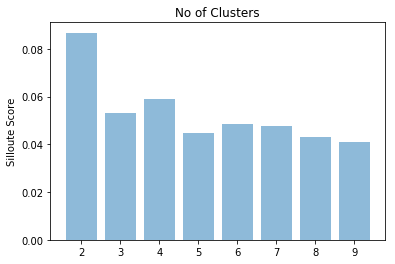

In [0]:
plot_silloute(silloute_score , objects)

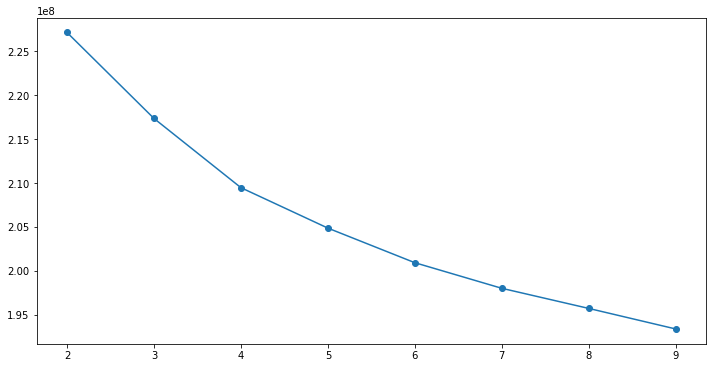

In [0]:
clusters_df = pd.DataFrame( { "num_clusters":objects, "cluster_errors": cluster_errors } )
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [0]:
kmeans = KMeans(n_clusters=10, random_state=0, n_jobs=-1).fit(resnet50_feature_list_np)

In [0]:
images_path = img_path('zipper')

141


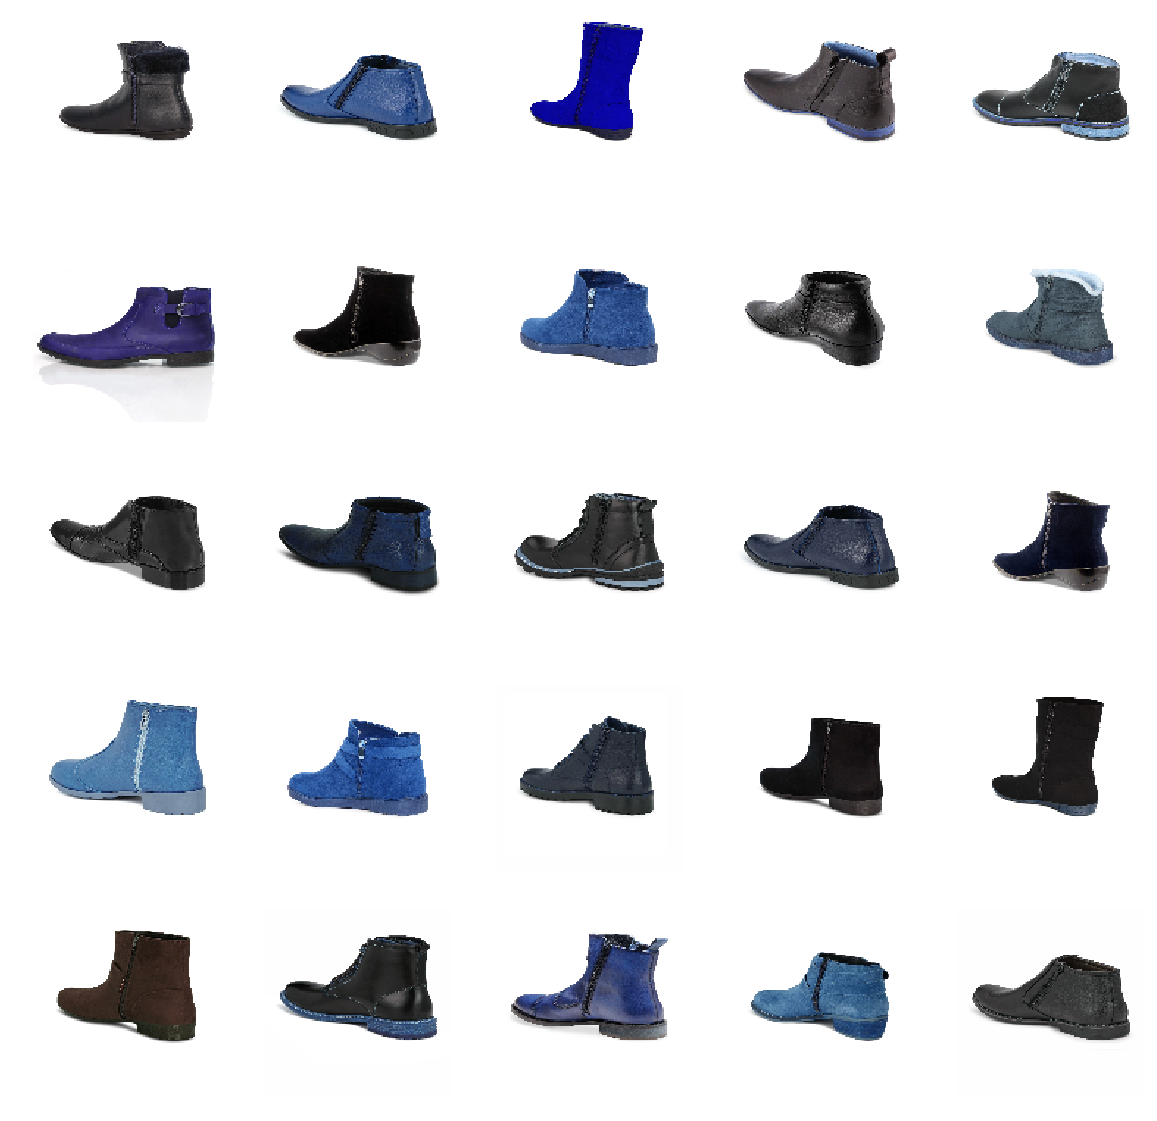

In [0]:
plot_cluster(images_path, kmeans.labels_, 4)

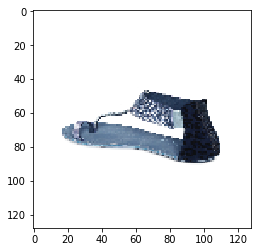

In [0]:
centre_image(images_path, kmeans.labels_, 2,resnet50_feature_list_np)

In [0]:
joblib.dump(kmeans , 'data/kmeans/kmeans_10_resnet_imagenet_zipper')

['data/kmeans/kmeans_10_resnet_imagenet_zipper']

In [0]:
images_no = [-1]
images = []
directory = listdir('data/zipper/')
kmeans = joblib.load('data/kmeans/kmeans_10_resnet_imagenet_zipper')


    
def write_image(best_img,cluster_no):
    key = ['temp']
    value = ['temp']
    data_directory = listdir('data/zipper/')
    for i in best_img[1:] :
        if type(i)==dict:
            key.append( list(i.keys())[0] )
            value.append( list(i.values())[0] )
        else:
            key.append('temp')
            value.append('temp')
            
    if key.count(cluster_no)>1 : 
        image_name = best_img[0]
        dict_index = [0]
        for i in best_img[1:] :
            if type(i)==dict:
                if (list(i.keys())[0] ==cluster_no) :
                    if dict_index[0] == 0 :
                        index_no = best_img.index(i)
                        value_distance = list( i.values() )[0]
                        dict_index[0] = {index_no:value_distance}
                    
                    else :
                        index_no = best_img.index(i)
                        value_distance = list( i.values() )[0]
                        if list(dict_index[0].values())[0] > value_distance :
                            dict_index[0]={index_no:value_distance}
                                            
        best_image_view = str( list( dict_index[0].keys() )[0] )    
        best_image_name = 'view_'+best_image_view+'-'+image_name
        img = cv2.imread('data/zipper/'+best_image_name)
        img = cv2.resize(img , (512,512))
        cv2.imwrite('data/BV/zipper/'+best_image_name,img)
        for k in ['view_1','view_2','view_3','view_4','view_5']:
            full_image_name = image_name+'_'+k+'.jpg'
            if (full_image_name in data_directory and full_image_name!=best_image_name):
                img = cv2.imread('data/zipper/'+full_image_name)
                img = cv2.resize(img , (512,512))
                cv2.imwrite('data/NBV/zipper/'+k+'-'+image_name,img)
                
    else :
        image_name = best_img[0]
        dict_index = [0]
        print (best_img)
        for i in best_img[1:]:
            if type(i) == dict :
                if (list(i.keys())[0] ==cluster_no) :
                    index_no = best_img.index(i)
                    value_distance = list( i.values() )[0]
                    dict_index[0] = {index_no:value_distance}
                    
        print (dict_index)
        best_image_view = str( list( dict_index[0].keys() )[0] )    
        best_image_name = 'view_'+best_image_view+'-'+image_name
        img = cv2.imread('data/zipper/'+best_image_name)
        img = cv2.resize(img , (512,512))
        cv2.imwrite('data/BV/zipper/'+best_image_name,img)
        for k in ['view_1','view_2','view_3','view_4','view_5']:
            full_image_name = k+'-'+image_name
            if (full_image_name in data_directory and full_image_name!=best_image_name):
                img = cv2.imread('data/zipper/'+full_image_name)
                img = cv2.resize(img , (512,512))
                cv2.imwrite('data/NBV/zipper/'+k+'-'+image_name,img)
                
            
def write_all_image(best_img):
    data_directory = listdir('data/zipper/')
    image_name = best_img[0]
    for k in ['view_1','view_2','view_3','view_4','view_5']:
        full_image_name = k+'-'+image_name
        if (full_image_name in data_directory ):
            img = cv2.imread('data/zipper/'+full_image_name)
            img = cv2.resize(img , (512,512))
            cv2.imwrite('data/NBV/zipper/'+k+'-'+image_name,img)
    

    
def same_image(images):
    images_cmp = []
    best_img = [0]*6
    best_img[0]=images
    for j in ['view_1','view_2','view_3','view_4','view_5']:
        image_path = j+'-'+images

        if image_path in directory :
            images_cmp.append('data/zipper/'+image_path)
                
    return images_cmp,best_img


for i in directory :
    item = i.split('-')[1]
    if item[1] == images_no[-1]:
        pass
    else :
        images_no.append(item[1])
        images.append(item)


    
for k in range(len(images)) :
    print ("---------------------------------")
    images_cmp,best_img = same_image(images[k])
    print (images_cmp)
    for l in images_cmp :
        img = image.load_img(l, target_size=(128, 128))
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        img_data = preprocess_input(img_data)
        resnet50_feature = model.predict(img_data)
        resnet50_feature = np.array(resnet50_feature.flatten())
        resnet50_feature = np.array(resnet50_feature)
        resnet50_feature = np.expand_dims(resnet50_feature, axis=0)
        pred_view = kmeans.predict(resnet50_feature)
        l_index = int(l.split('_')[1].split('-')[0])
        result = spatial.distance.cosine(kmeans.cluster_centers_[pred_view[0]],resnet50_feature.flatten())
        best_img[l_index] = {pred_view[0]:result}
          
             
    key =[]
    for m in range(1,len(best_img)):

        if (type(best_img[m]) == dict):
            key.append( list(best_img[m].keys())[0] )
            
            
    if 4 in key :
        write_image(best_img,4)
        continue
    
    elif 2 in key :
        write_image(best_img,2)
        continue
       
    elif 3 in key :
        write_image(best_img,3)
        continue
        
    elif 6 in key :
        write_image(best_img,6)
        continue
  
    else :
        print ('No best view could be determined for this Image')
        write_all_image(best_img)
        continue

In [0]:
# Buckle

In [0]:
resnet50_feature_list_np = get_vec_footwear('buckle')
resnet50_feature_list_np.shape

(694, 32768)

In [0]:
silloute_score , objects , cluster_errors = get_clusters(2,10,resnet50_feature_list_np)

2
3
4
5
6
7
8
9


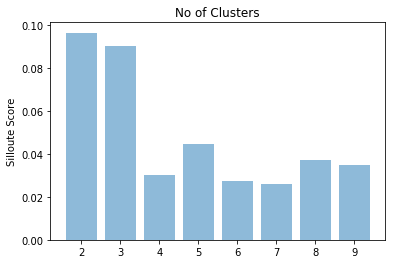

In [0]:
plot_silloute(silloute_score , objects)

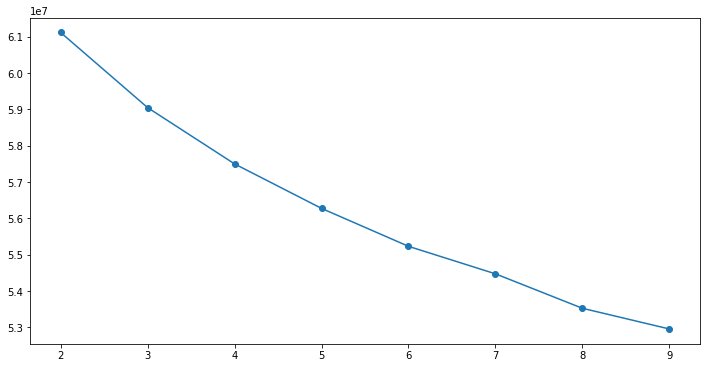

In [0]:
clusters_df = pd.DataFrame( { "num_clusters":objects, "cluster_errors": cluster_errors } )
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [0]:
kmeans = KMeans(n_clusters=8, random_state=0, n_jobs=-1).fit(resnet50_feature_list_np)

In [0]:
images_path = img_path('buckle')

184


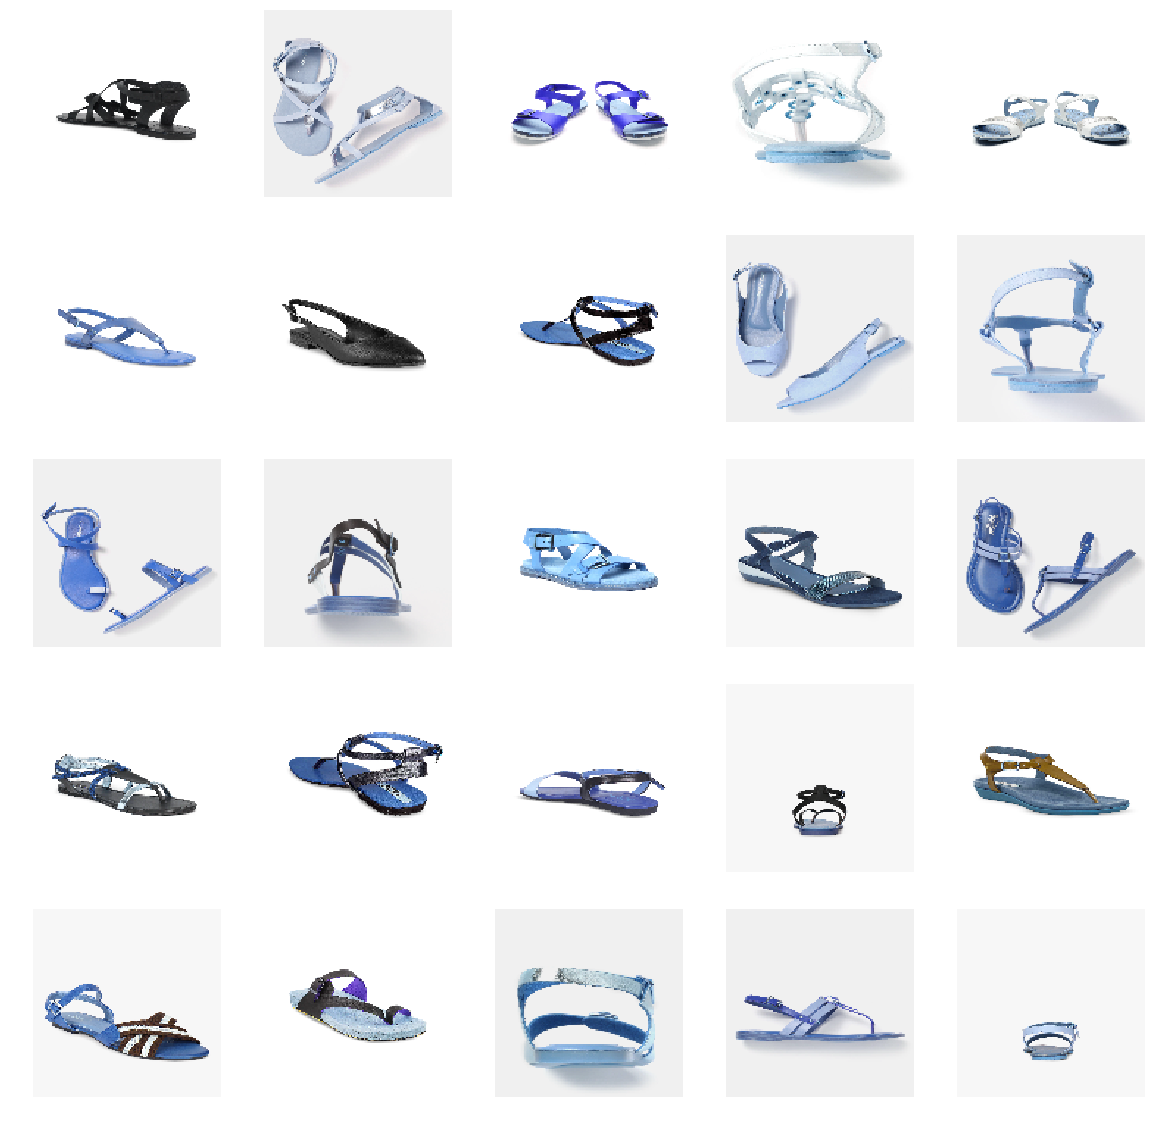

In [0]:
plot_cluster(images_path, kmeans.labels_, 0)

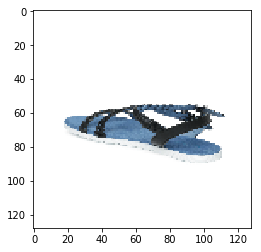

In [0]:
centre_image(images_path, kmeans.labels_, 0,resnet50_feature_list_np)

In [0]:
joblib.dump(kmeans , 'data/kmeans/kmeans_8_resnet_imagenet_buckle')

['data/kmeans/kmeans_8_resnet_imagenet_buckle']

In [0]:
images_no = [-1]
images = []
directory = listdir('data/buckle/')
kmeans = joblib.load('data/kmeans/kmeans_8_resnet_imagenet_buckle')

    
def write_image(best_img,cluster_no):
    key = ['temp']
    value = ['temp']
    data_directory = listdir('data/buckle/')
    for i in best_img[1:] :
        if type(i)==dict:
            key.append( list(i.keys())[0] )
            value.append( list(i.values())[0] )
        else:
            key.append('temp')
            value.append('temp')
            
    if key.count(cluster_no)>1 : 
        image_name = best_img[0]
        dict_index = [0]
        for i in best_img[1:] :
            if type(i)==dict:
                if (list(i.keys())[0] ==cluster_no) :
                    if dict_index[0] == 0 :
                        index_no = best_img.index(i)
                        value_distance = list( i.values() )[0]
                        dict_index[0] = {index_no:value_distance}
                    
                    else :
                        index_no = best_img.index(i)
                        value_distance = list( i.values() )[0]
                        if list(dict_index[0].values())[0] > value_distance :
                            dict_index[0]={index_no:value_distance}
                                            
        best_image_view = str( list( dict_index[0].keys() )[0] )    
        best_image_name = 'view_'+best_image_view+'-'+image_name
        img = cv2.imread('data/buckle/'+best_image_name)
        img = cv2.resize(img , (512,512))
        cv2.imwrite('data/BV/buckle/'+best_image_name,img)
        for k in ['view_1','view_2','view_3','view_4','view_5']:
            full_image_name = image_name+'_'+k+'.jpg'
            if (full_image_name in data_directory and full_image_name!=best_image_name):
                img = cv2.imread('data/buckle/'+full_image_name)
                img = cv2.resize(img , (512,512))
                cv2.imwrite('data/NBV/buckle/'+k+'-'+image_name,img)
                
    else :
        image_name = best_img[0]
        dict_index = [0]
        print (best_img)
        for i in best_img[1:]:
            if type(i) == dict :
                if (list(i.keys())[0] ==cluster_no) :
                    index_no = best_img.index(i)
                    value_distance = list( i.values() )[0]
                    dict_index[0] = {index_no:value_distance}
                    
        print (dict_index)
        best_image_view = str( list( dict_index[0].keys() )[0] )    
        best_image_name = 'view_'+best_image_view+'-'+image_name
        img = cv2.imread('data/buckle/'+best_image_name)
        img = cv2.resize(img , (512,512))
        cv2.imwrite('data/BV/buckle/'+best_image_name,img)
        for k in ['view_1','view_2','view_3','view_4','view_5']:
            full_image_name = k+'-'+image_name
            if (full_image_name in data_directory and full_image_name!=best_image_name):
                img = cv2.imread('data/buckle/'+full_image_name)
                img = cv2.resize(img , (512,512))
                cv2.imwrite('data/NBV/buckle/'+k+'-'+image_name,img)
                
            
def write_all_image(best_img):
    data_directory = listdir('data/buckle/')
    image_name = best_img[0]
    for k in ['view_1','view_2','view_3','view_4','view_5']:
        full_image_name = k+'-'+image_name
        if (full_image_name in data_directory ):
            img = cv2.imread('data/buckle/'+full_image_name)
            img = cv2.resize(img , (512,512))
            cv2.imwrite('data/NBV/buckle/'+k+'-'+image_name,img)
    
    
def same_image(images):
    images_cmp = []
    best_img = [0]*6
    best_img[0]=images
    for j in ['view_1','view_2','view_3','view_4','view_5']:
        image_path = j+'-'+images

        if image_path in directory :
            images_cmp.append('data/buckle/'+image_path)
                
    return images_cmp,best_img


for i in directory :
    item = i.split('-')[1]
    if item[1] == images_no[-1]:
        pass
    else :
        images_no.append(item[1])
        images.append(item)

    
for k in range(len(images)) :
    print ("---------------------------------")
    images_cmp,best_img = same_image(images[k])
    print (images_cmp)
    for l in images_cmp :
        img = image.load_img(l, target_size=(128, 128))
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        img_data = preprocess_input(img_data)
        resnet50_feature = model.predict(img_data)
        resnet50_feature = np.array(resnet50_feature.flatten())
        resnet50_feature = np.array(resnet50_feature)
        resnet50_feature = np.expand_dims(resnet50_feature, axis=0)
        pred_view = kmeans.predict(resnet50_feature)
        l_index = int(l.split('_')[1].split('-')[0])
        result = spatial.distance.cosine(kmeans.cluster_centers_[pred_view[0]],resnet50_feature.flatten())
        best_img[l_index] = {pred_view[0]:result}
          
             
    key =[]
    for m in range(1,len(best_img)):

        if (type(best_img[m]) == dict):
            key.append( list(best_img[m].keys())[0] )
            
            
    if 0 in key :
        write_image(best_img,0)
        continue
    
       
    elif 3 in key :
        write_image(best_img,3)
        continue
        
    elif 6 in key :
        write_image(best_img,6)
        continue
    
    elif 4 in key :
        write_image(best_img,4)
        continue
        
   
  
    else :
        print ('No best view could be determined for this Image')
        write_all_image(best_img)
        continue


In [0]:
# Slip On

In [0]:
resnet50_feature_list_np = get_vec_footwear('slip_on')
resnet50_feature_list_np.shape

(2117, 32768)

In [0]:
silloute_score , objects , cluster_errors = get_clusters(2,10,resnet50_feature_list_np)

2
3
4
5
6
7
8
9


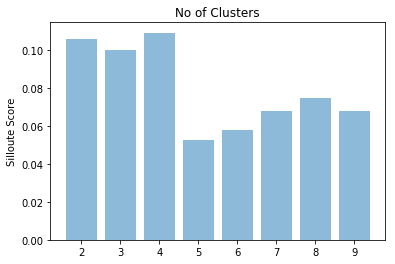

In [0]:
plot_silloute(silloute_score , objects)

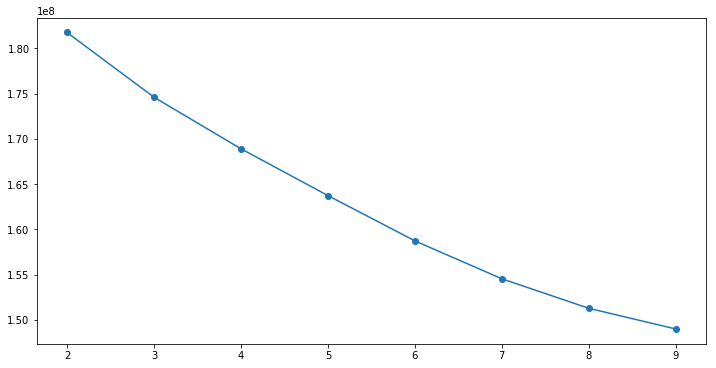

In [0]:
clusters_df = pd.DataFrame( { "num_clusters":objects, "cluster_errors": cluster_errors } )
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [0]:
kmeans = KMeans(n_clusters=8, random_state=0, n_jobs=-1).fit(resnet50_feature_list_np)

In [0]:
images_path = img_path('slip_on')

116


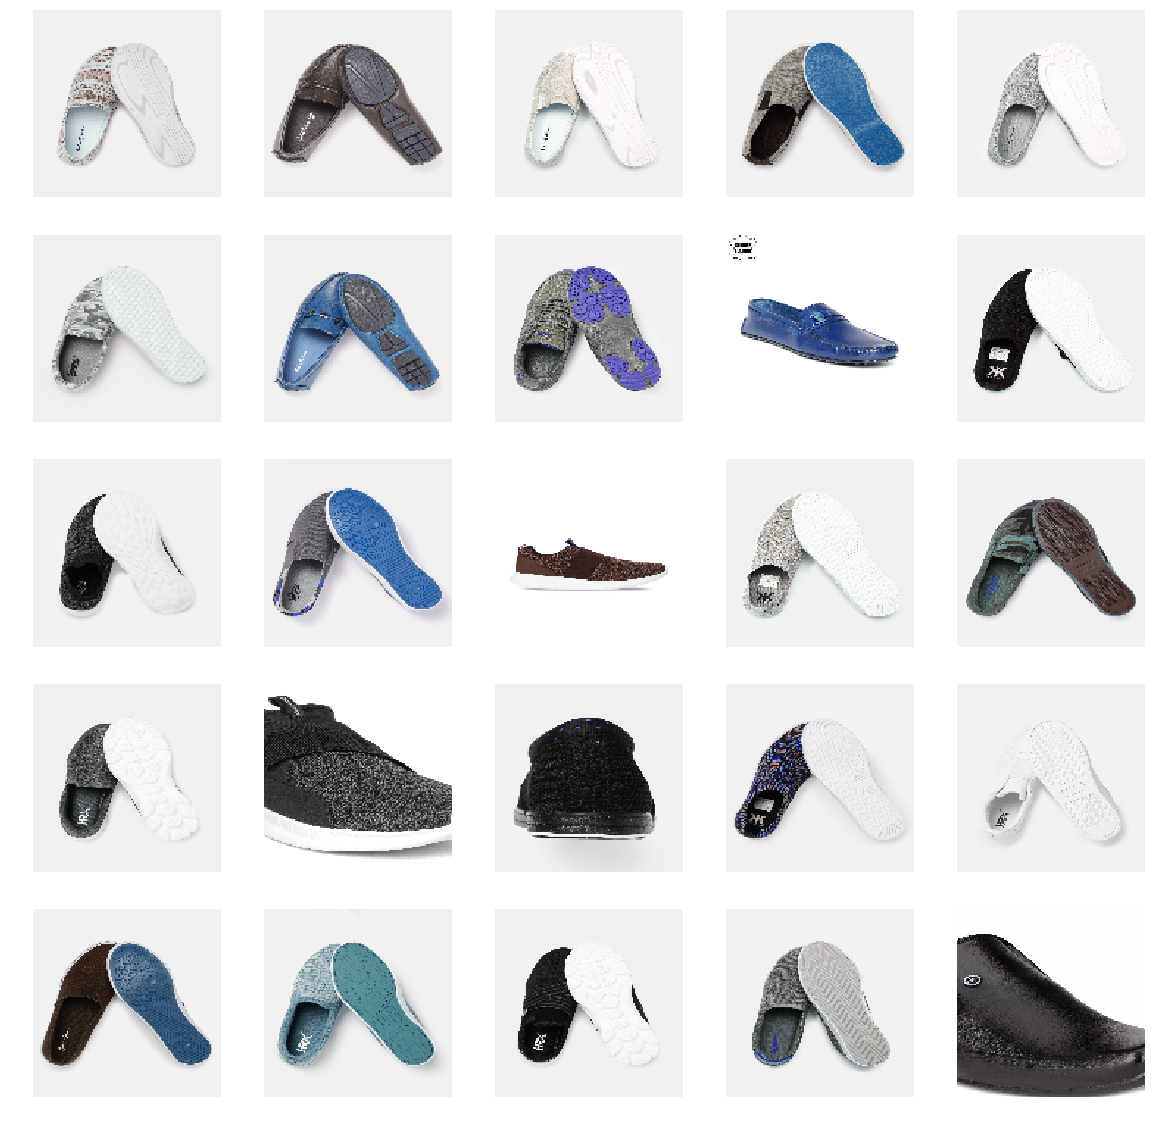

In [0]:
plot_cluster(images_path, kmeans.labels_, 6)

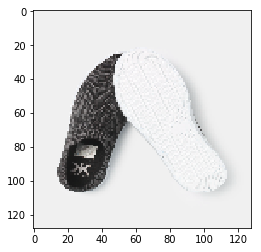

In [0]:
centre_image(images_path, kmeans.labels_, 6,resnet50_feature_list_np)

In [0]:
joblib.dump(kmeans , 'data/kmeans/kmeans_8_resnet_imagenet_slip_on')

['data/kmeans/kmeans_8_resnet_imagenet_slip_on']

In [0]:
images_no = [-1]
images = []
directory = listdir('data/slip_on/')
kmeans = joblib.load('data/kmeans/kmeans_8_resnet_imagenet_slip_on')

    
def write_image(best_img,cluster_no):
    key = ['temp']
    value = ['temp']
    data_directory = listdir('data/slip_on/')
    for i in best_img[1:] :
        if type(i)==dict:
            key.append( list(i.keys())[0] )
            value.append( list(i.values())[0] )
        else:
            key.append('temp')
            value.append('temp')
            
    if key.count(cluster_no)>1 : 
        image_name = best_img[0]
        dict_index = [0]
        for i in best_img[1:] :
            if type(i)==dict:
                if (list(i.keys())[0] ==cluster_no) :
                    if dict_index[0] == 0 :
                        index_no = best_img.index(i)
                        value_distance = list( i.values() )[0]
                        dict_index[0] = {index_no:value_distance}
                    
                    else :
                        index_no = best_img.index(i)
                        value_distance = list( i.values() )[0]
                        if list(dict_index[0].values())[0] > value_distance :
                            dict_index[0]={index_no:value_distance}
                                            
        best_image_view = str( list( dict_index[0].keys() )[0] )    
        best_image_name = 'view_'+best_image_view+'-'+image_name
        img = cv2.imread('data/slip_on/'+best_image_name)
        img = cv2.resize(img , (512,512))
        cv2.imwrite('data/BV/slip_on/'+best_image_name,img)
        for k in ['view_1','view_2','view_3','view_4','view_5']:
            full_image_name = image_name+'_'+k+'.jpg'
            if (full_image_name in data_directory and full_image_name!=best_image_name):
                img = cv2.imread('data/slip_on/'+full_image_name)
                img = cv2.resize(img , (512,512))
                cv2.imwrite('data/NBV/slip_on/'+k+'-'+image_name,img)
                
    else :
        image_name = best_img[0]
        dict_index = [0]
        print (best_img)
        for i in best_img[1:]:
            if type(i) == dict :
                if (list(i.keys())[0] ==cluster_no) :
                    index_no = best_img.index(i)
                    value_distance = list( i.values() )[0]
                    dict_index[0] = {index_no:value_distance}
                    
        print (dict_index)
        best_image_view = str( list( dict_index[0].keys() )[0] )    
        best_image_name = 'view_'+best_image_view+'-'+image_name
        img = cv2.imread('data/slip_on/'+best_image_name)
        img = cv2.resize(img , (512,512))
        cv2.imwrite('data/BV/slip_on/'+best_image_name,img)
        for k in ['view_1','view_2','view_3','view_4','view_5']:
            full_image_name = k+'-'+image_name
            if (full_image_name in data_directory and full_image_name!=best_image_name):
                img = cv2.imread('data/slip_on/'+full_image_name)
                img = cv2.resize(img , (512,512))
                cv2.imwrite('data/NBV/slip_on/'+k+'-'+image_name,img)
                
            
def write_all_image(best_img):
    data_directory = listdir('data/slip_on/')
    image_name = best_img[0]
    for k in ['view_1','view_2','view_3','view_4','view_5']:
        full_image_name = k+'-'+image_name
        if (full_image_name in data_directory ):
            img = cv2.imread('data/slip_on/'+full_image_name)
            img = cv2.resize(img , (512,512))
            cv2.imwrite('data/NBV/slip_on/'+k+'-'+image_name,img)
    
    
def same_image(images):
    images_cmp = []
    best_img = [0]*6
    best_img[0]=images
    for j in ['view_1','view_2','view_3','view_4','view_5']:
        image_path = j+'-'+images

        if image_path in directory :
            images_cmp.append('data/slip_on/'+image_path)
                
    return images_cmp,best_img


for i in directory :
    item = i.split('-')[1]
    if item[1] == images_no[-1]:
        pass
    else :
        images_no.append(item[1])
        images.append(item)

    
for k in range(len(images)) :
    print ("---------------------------------")
    try:
      images_cmp,best_img = same_image(images[k])
      print (images_cmp)
      for l in images_cmp :
          img = image.load_img(l, target_size=(128, 128))
          img_data = image.img_to_array(img)
          img_data = np.expand_dims(img_data, axis=0)
          img_data = preprocess_input(img_data)
          resnet50_feature = model.predict(img_data)
          resnet50_feature = np.array(resnet50_feature.flatten())
          resnet50_feature = np.array(resnet50_feature)
          resnet50_feature = np.expand_dims(resnet50_feature, axis=0)
          pred_view = kmeans.predict(resnet50_feature)
          l_index = int(l.split('_')[2].split('-')[0])
          result = spatial.distance.cosine(kmeans.cluster_centers_[pred_view[0]],resnet50_feature.flatten())
          best_img[l_index] = {pred_view[0]:result}



      key =[]
      for m in range(1,len(best_img)):

          if (type(best_img[m]) == dict):
              key.append( list(best_img[m].keys())[0] )


      if 2 in key :
          write_image(best_img,2)
          continue


      elif 3 in key :
          write_image(best_img,3)
          continue

      elif 4 in key :
          write_image(best_img,4)
          continue

      elif 1 in key :
          write_image(best_img,1)
          continue

      elif 7 in key :
          write_image(best_img,1)
          continue

      elif 6 in key :
          write_image(best_img,1)
          continue


      else :
          print ('No best view could be determined for this Image')
          write_all_image(best_img)
          continue
    except:
        pass   

In [0]:
# Backstrap

In [0]:
resnet50_feature_list_np = get_vec_footwear('backstrap')
resnet50_feature_list_np.shape

(1655, 32768)

In [0]:
silloute_score , objects , cluster_errors = get_clusters(2,10,resnet50_feature_list_np)

2
3
4
5
6
7
8
9


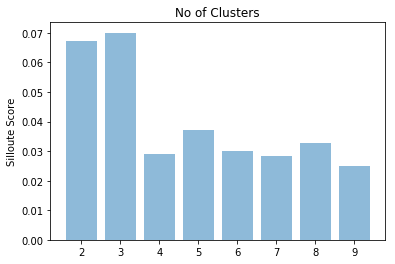

In [0]:
plot_silloute(silloute_score , objects)

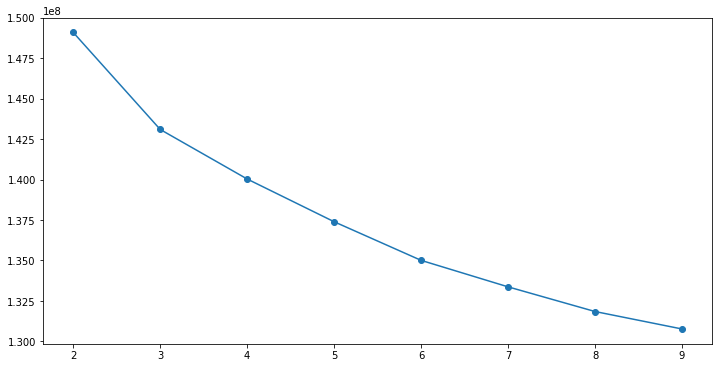

In [0]:
clusters_df = pd.DataFrame( { "num_clusters":objects, "cluster_errors": cluster_errors } )
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [0]:
kmeans = KMeans(n_clusters=8, random_state=0, n_jobs=-1).fit(resnet50_feature_list_np)

In [0]:
images_path = img_path('backstrap')

231


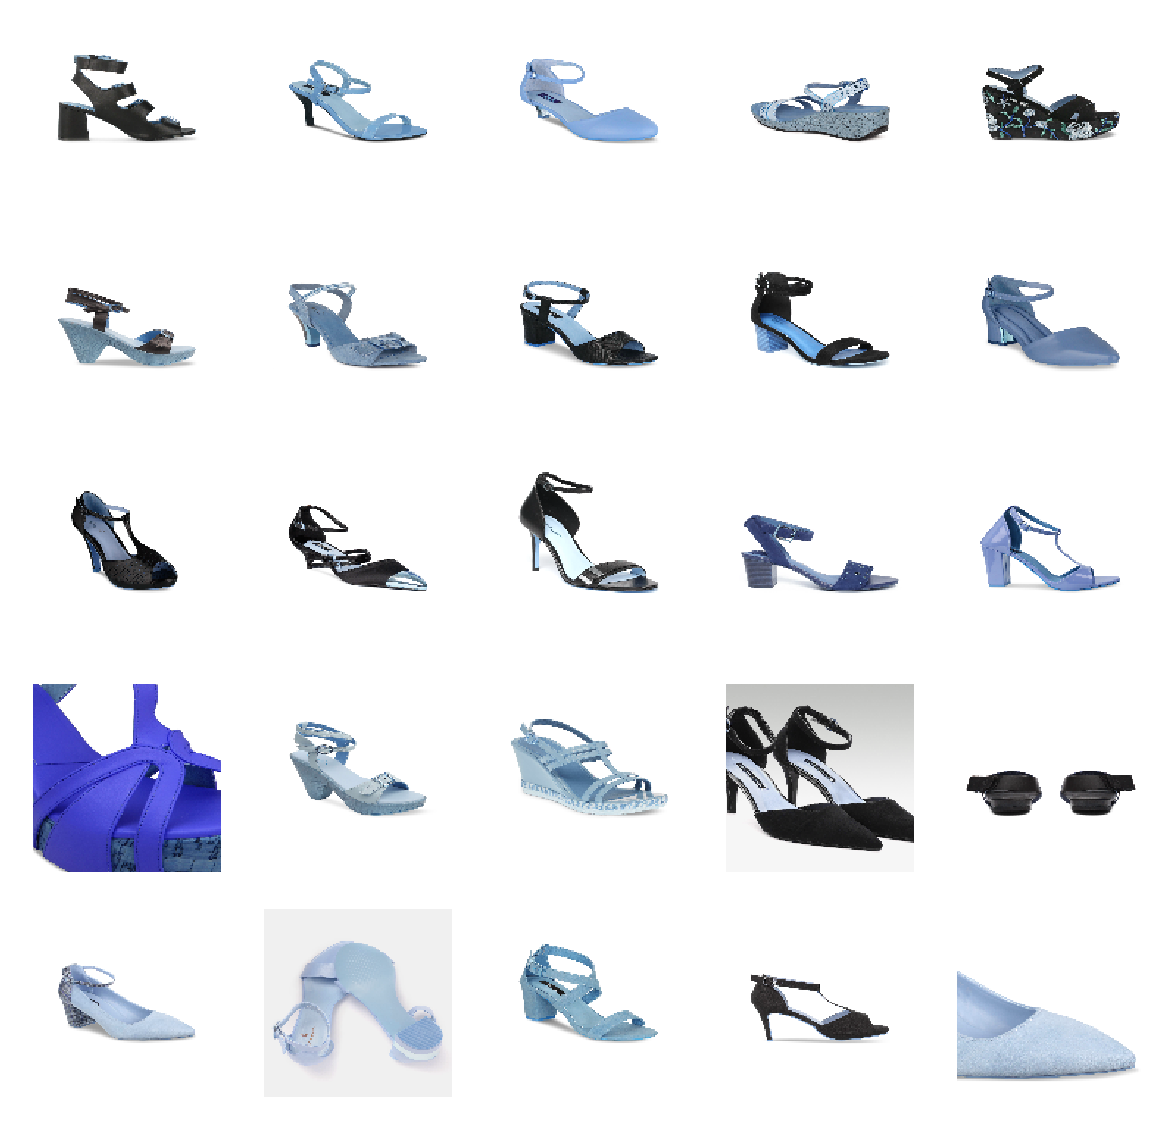

In [0]:
plot_cluster(images_path, kmeans.labels_, 4)

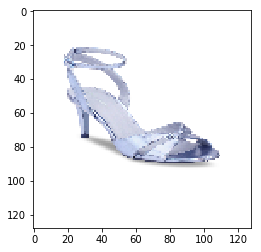

In [0]:
centre_image(images_path, kmeans.labels_, 4,resnet50_feature_list_np)

In [0]:
joblib.dump(kmeans , 'data/kmeans/kmeans_8_resnet_imagenet_backstrap')

['data/kmeans/kmeans_8_resnet_imagenet_backstrap']

In [0]:
images_no = [-1]
images = []
directory = listdir('data/backstrap/')
kmeans = joblib.load('data/kmeans/kmeans_8_resnet_imagenet_backstrap')

    
def write_image(best_img,cluster_no):
    key = ['temp']
    value = ['temp']
    data_directory = listdir('data/backstrap/')
    for i in best_img[1:] :
        if type(i)==dict:
            key.append( list(i.keys())[0] )
            value.append( list(i.values())[0] )
        else:
            key.append('temp')
            value.append('temp')
            
    if key.count(cluster_no)>1 : 
        image_name = best_img[0]
        dict_index = [0]
        for i in best_img[1:] :
            if type(i)==dict:
                if (list(i.keys())[0] ==cluster_no) :
                    if dict_index[0] == 0 :
                        index_no = best_img.index(i)
                        value_distance = list( i.values() )[0]
                        dict_index[0] = {index_no:value_distance}
                    
                    else :
                        index_no = best_img.index(i)
                        value_distance = list( i.values() )[0]
                        if list(dict_index[0].values())[0] > value_distance :
                            dict_index[0]={index_no:value_distance}
                                            
        best_image_view = str( list( dict_index[0].keys() )[0] )    
        best_image_name = 'view_'+best_image_view+'-'+image_name
        img = cv2.imread('data/backstrap/'+best_image_name)
        img = cv2.resize(img , (512,512))
        cv2.imwrite('data/BV/backstrap/'+best_image_name,img)
        for k in ['view_1','view_2','view_3','view_4','view_5']:
            full_image_name = image_name+'_'+k+'.jpg'
            if (full_image_name in data_directory and full_image_name!=best_image_name):
                img = cv2.imread('data/backstrap/'+full_image_name)
                img = cv2.resize(img , (512,512))
                cv2.imwrite('data/NBV/backstrap/'+k+'-'+image_name,img)
                
    else :
        image_name = best_img[0]
        dict_index = [0]
        print (best_img)
        for i in best_img[1:]:
            if type(i) == dict :
                if (list(i.keys())[0] ==cluster_no) :
                    index_no = best_img.index(i)
                    value_distance = list( i.values() )[0]
                    dict_index[0] = {index_no:value_distance}
                    
        print (dict_index)
        best_image_view = str( list( dict_index[0].keys() )[0] )    
        best_image_name = 'view_'+best_image_view+'-'+image_name
        img = cv2.imread('data/backstrap/'+best_image_name)
        img = cv2.resize(img , (512,512))
        cv2.imwrite('data/BV/backstrap/'+best_image_name,img)
        for k in ['view_1','view_2','view_3','view_4','view_5']:
            full_image_name = k+'-'+image_name
            if (full_image_name in data_directory and full_image_name!=best_image_name):
                img = cv2.imread('data/backstrap/'+full_image_name)
                img = cv2.resize(img , (512,512))
                cv2.imwrite('data/NBV/backstrap/'+k+'-'+image_name,img)
                
            
def write_all_image(best_img):
    data_directory = listdir('data/backstrap/')
    image_name = best_img[0]
    for k in ['view_1','view_2','view_3','view_4','view_5']:
        full_image_name = k+'-'+image_name
        if (full_image_name in data_directory ):
            img = cv2.imread('data/backstrap/'+full_image_name)
            img = cv2.resize(img , (512,512))
            cv2.imwrite('data/NBV/backstrap/'+k+'-'+image_name,img)
    
    
def same_image(images):
    images_cmp = []
    best_img = [0]*6
    best_img[0]=images
    for j in ['view_1','view_2','view_3','view_4','view_5']:
        image_path = j+'-'+images

        if image_path in directory :
            images_cmp.append('data/backstrap/'+image_path)
                
    return images_cmp,best_img


for i in directory :
    item = i.split('-')[1]
    if item[1] == images_no[-1]:
        pass
    else :
        images_no.append(item[1])
        images.append(item)

    
for k in range(len(images)) :
    print ("---------------------------------")
    try:
      images_cmp,best_img = same_image(images[k])
      print (images_cmp)
      for l in images_cmp :
          img = image.load_img(l, target_size=(128, 128))
          img_data = image.img_to_array(img)
          img_data = np.expand_dims(img_data, axis=0)
          img_data = preprocess_input(img_data)
          resnet50_feature = model.predict(img_data)
          resnet50_feature = np.array(resnet50_feature.flatten())
          resnet50_feature = np.array(resnet50_feature)
          resnet50_feature = np.expand_dims(resnet50_feature, axis=0)
          pred_view = kmeans.predict(resnet50_feature)
          l_index = int(l.split('_')[1].split('-')[0])
          result = spatial.distance.cosine(kmeans.cluster_centers_[pred_view[0]],resnet50_feature.flatten())
          best_img[l_index] = {pred_view[0]:result}


      key =[]
      for m in range(1,len(best_img)):

          if (type(best_img[m]) == dict):
              key.append( list(best_img[m].keys())[0] )


      if 4 in key :
          write_image(best_img,4)
          continue


      elif 7 in key :
          write_image(best_img,7)
          continue

      elif 1 in key :
          write_image(best_img,1)
          continue

      elif 3 in key :
          write_image(best_img,3)
          continue



      else :
          print ('No best view could be determined for this Image')
          write_all_image(best_img)
          continue
          
    except:
      pass

In [0]:
# Lace Up

In [0]:
resnet50_feature_list_np = get_vec_footwear('lace_up')
resnet50_feature_list_np.shape

(2259, 32768)

In [0]:
silloute_score , objects , cluster_errors = get_clusters(2,10,resnet50_feature_list_np)

2
3
4
5
6
7
8
9


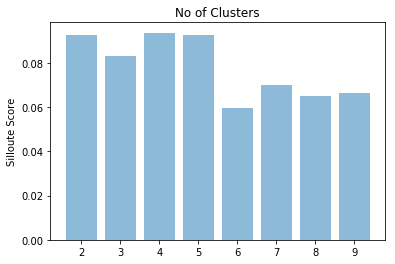

In [0]:
plot_silloute(silloute_score , objects)

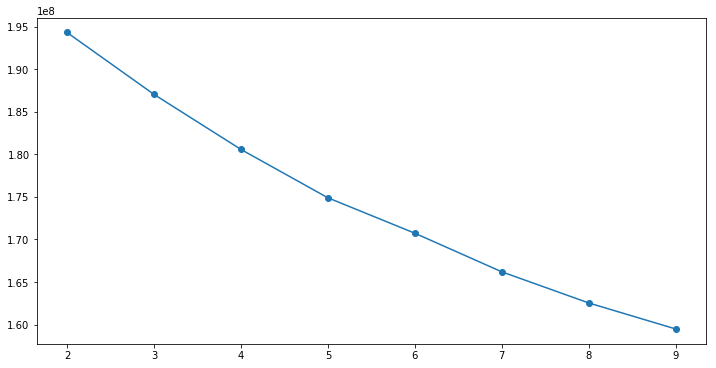

In [0]:
clusters_df = pd.DataFrame( { "num_clusters":objects, "cluster_errors": cluster_errors } )
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [0]:
kmeans = KMeans(n_clusters=8, random_state=0, n_jobs=-1).fit(resnet50_feature_list_np)

In [0]:
images_path = img_path('lace_up')

174


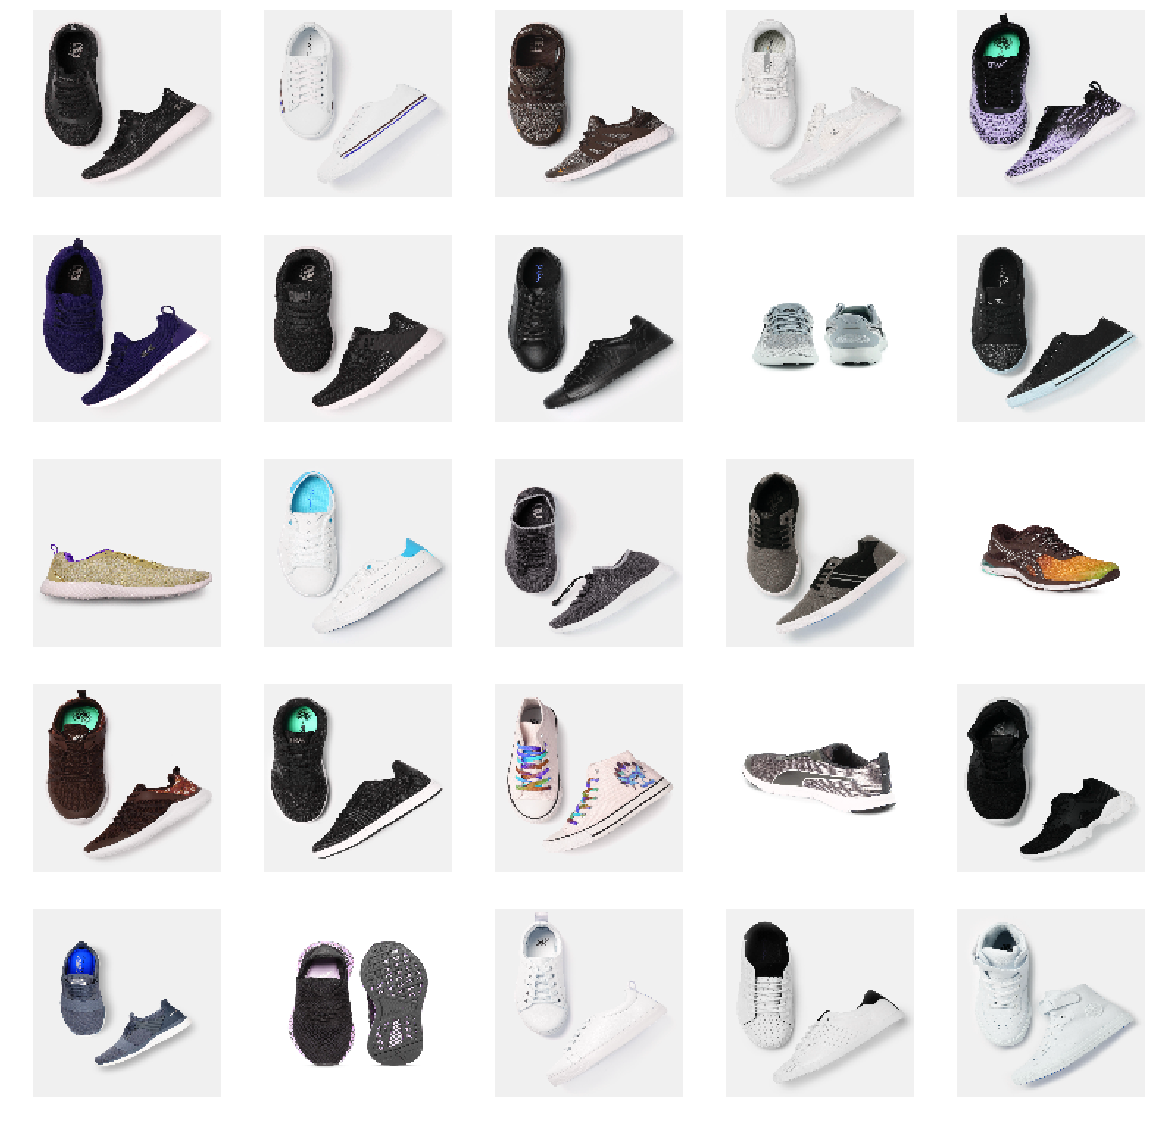

In [0]:
plot_cluster(images_path, kmeans.labels_, 1)

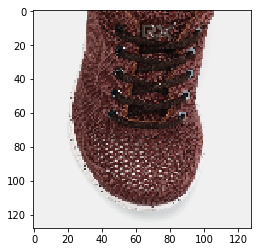

In [0]:
centre_image(images_path, kmeans.labels_, 2,resnet50_feature_list_np)

In [0]:
joblib.dump(kmeans , 'data/kmeans/kmeans_8_resnet_imagenet_lace_up')

['data/kmeans/kmeans_8_resnet_imagenet_lace_up']

In [0]:
images_no = [-1]
images = []
directory = listdir('data/lace_up/')
kmeans = joblib.load('data/kmeans/kmeans_8_resnet_imagenet_lace_up')

    
def write_image(best_img,cluster_no):
    key = ['temp']
    value = ['temp']
    data_directory = listdir('data/lace_up/')
    for i in best_img[1:] :
        if type(i)==dict:
            key.append( list(i.keys())[0] )
            value.append( list(i.values())[0] )
        else:
            key.append('temp')
            value.append('temp')
            
    if key.count(cluster_no)>1 : 
        image_name = best_img[0]
        dict_index = [0]
        for i in best_img[1:] :
            if type(i)==dict:
                if (list(i.keys())[0] ==cluster_no) :
                    if dict_index[0] == 0 :
                        index_no = best_img.index(i)
                        value_distance = list( i.values() )[0]
                        dict_index[0] = {index_no:value_distance}
                    
                    else :
                        index_no = best_img.index(i)
                        value_distance = list( i.values() )[0]
                        if list(dict_index[0].values())[0] > value_distance :
                            dict_index[0]={index_no:value_distance}
                                            
        best_image_view = str( list( dict_index[0].keys() )[0] )    
        best_image_name = 'view_'+best_image_view+'-'+image_name
        img = cv2.imread('data/lace_up/'+best_image_name)
        img = cv2.resize(img , (512,512))
        cv2.imwrite('data/BV/lace_up/'+best_image_name,img)
        for k in ['view_1','view_2','view_3','view_4','view_5']:
            full_image_name = image_name+'_'+k+'.jpg'
            if (full_image_name in data_directory and full_image_name!=best_image_name):
                img = cv2.imread('data/lace_up/'+full_image_name)
                img = cv2.resize(img , (512,512))
                cv2.imwrite('data/NBV/lace_up/'+k+'-'+image_name,img)
                
    else :
        image_name = best_img[0]
        dict_index = [0]
        print (best_img)
        for i in best_img[1:]:
            if type(i) == dict :
                if (list(i.keys())[0] ==cluster_no) :
                    index_no = best_img.index(i)
                    value_distance = list( i.values() )[0]
                    dict_index[0] = {index_no:value_distance}
                    
        print (dict_index)
        best_image_view = str( list( dict_index[0].keys() )[0] )    
        best_image_name = 'view_'+best_image_view+'-'+image_name
        img = cv2.imread('data/lace_up/'+best_image_name)
        img = cv2.resize(img , (512,512))
        cv2.imwrite('data/BV/lace_up/'+best_image_name,img)
        for k in ['view_1','view_2','view_3','view_4','view_5']:
            full_image_name = k+'-'+image_name
            if (full_image_name in data_directory and full_image_name!=best_image_name):
                img = cv2.imread('data/lace_up/'+full_image_name)
                img = cv2.resize(img , (512,512))
                cv2.imwrite('data/NBV/lace_up/'+k+'-'+image_name,img)
                
            
def write_all_image(best_img):
    data_directory = listdir('data/lace_up/')
    image_name = best_img[0]
    for k in ['view_1','view_2','view_3','view_4','view_5']:
        full_image_name = k+'-'+image_name
        if (full_image_name in data_directory ):
            img = cv2.imread('data/lace_up/'+full_image_name)
            img = cv2.resize(img , (512,512))
            cv2.imwrite('data/NBV/lace_up/'+k+'-'+image_name,img)
    
    
def same_image(images):
    images_cmp = []
    best_img = [0]*6
    best_img[0]=images
    for j in ['view_1','view_2','view_3','view_4','view_5']:
        image_path = j+'-'+images

        if image_path in directory :
            images_cmp.append('data/lace_up/'+image_path)
                
    return images_cmp,best_img


for i in directory :
    item = i.split('-')[1]
    if item[1] == images_no[-1]:
        pass
    else :
        images_no.append(item[1])
        images.append(item)

    
for k in range(len(images)) :
    print ("---------------------------------")
    try:
      images_cmp,best_img = same_image(images[k])
      print (images_cmp)
      for l in images_cmp :
          img = image.load_img(l, target_size=(128, 128))
          img_data = image.img_to_array(img)
          img_data = np.expand_dims(img_data, axis=0)
          img_data = preprocess_input(img_data)
          resnet50_feature = model.predict(img_data)
          resnet50_feature = np.array(resnet50_feature.flatten())
          resnet50_feature = np.array(resnet50_feature)
          resnet50_feature = np.expand_dims(resnet50_feature, axis=0)
          pred_view = kmeans.predict(resnet50_feature)
          l_index = int(l.split('_')[2].split('-')[0])
          result = spatial.distance.cosine(kmeans.cluster_centers_[pred_view[0]],resnet50_feature.flatten())
          best_img[l_index] = {pred_view[0]:result}


      key =[]
      for m in range(1,len(best_img)):

          if (type(best_img[m]) == dict):
              key.append( list(best_img[m].keys())[0] )


      if 2 in key :
          write_image(best_img,2)
          continue


      elif 7 in key :
          write_image(best_img,7)
          continue

      elif 3 in key :
          write_image(best_img,3)
          continue

      elif 1 in key :
          write_image(best_img,1)
          continue

      elif 0 in key :
          write_image(best_img,0)
          continue

      else :
          print ('No best view could be determined for this Image')
          write_all_image(best_img)
          continue
          
    except:
      pass

In [0]:
# Hook and Look

In [0]:
resnet50_feature_list_np = get_vec_footwear('hook&look')
resnet50_feature_list_np.shape

(1516, 32768)

In [0]:
silloute_score , objects , cluster_errors = get_clusters(2,10,resnet50_feature_list_np)

2
3
4
5
6
7
8
9


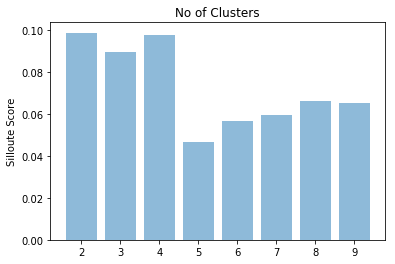

In [0]:
plot_silloute(silloute_score , objects)

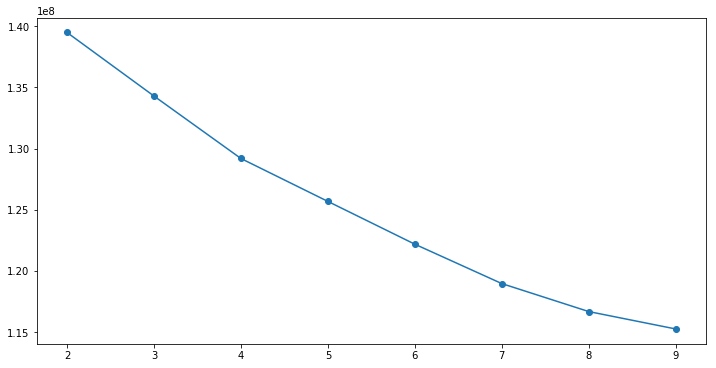

In [0]:
clusters_df = pd.DataFrame( { "num_clusters":objects, "cluster_errors": cluster_errors } )
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [0]:
kmeans = KMeans(n_clusters=8, random_state=0, n_jobs=-1).fit(resnet50_feature_list_np)

In [0]:
images_path = img_path('hook&look')

179


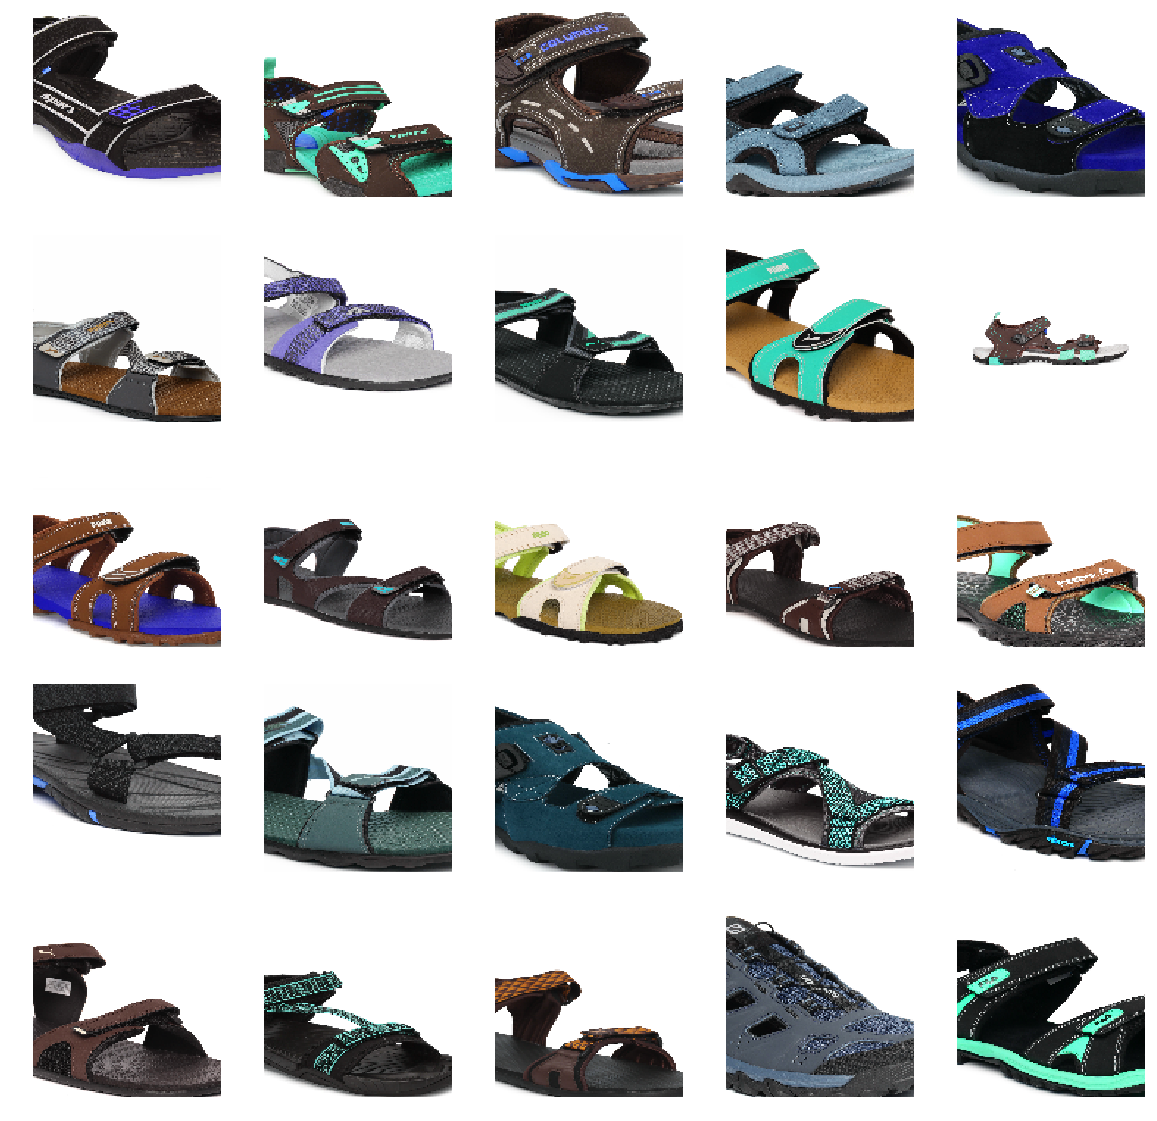

In [0]:
plot_cluster(images_path, kmeans.labels_, 4)

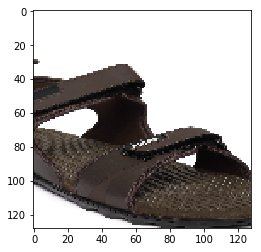

In [0]:
centre_image(images_path, kmeans.labels_, 4,resnet50_feature_list_np)

In [0]:
joblib.dump(kmeans , 'data/kmeans/kmeans_8_resnet_imagenet_hook&look')

['data/kmeans/kmeans_8_resnet_imagenet_hook&look']

In [0]:
images_no = [-1]
images = []
directory = listdir('data/hook&look/')
kmeans = joblib.load('data/kmeans/kmeans_8_resnet_imagenet_hook&look')

    
def write_image(best_img,cluster_no):
    key = ['temp']
    value = ['temp']
    data_directory = listdir('data/hook&look/')
    for i in best_img[1:] :
        if type(i)==dict:
            key.append( list(i.keys())[0] )
            value.append( list(i.values())[0] )
        else:
            key.append('temp')
            value.append('temp')
            
    if key.count(cluster_no)>1 : 
        image_name = best_img[0]
        dict_index = [0]
        for i in best_img[1:] :
            if type(i)==dict:
                if (list(i.keys())[0] ==cluster_no) :
                    if dict_index[0] == 0 :
                        index_no = best_img.index(i)
                        value_distance = list( i.values() )[0]
                        dict_index[0] = {index_no:value_distance}
                    
                    else :
                        index_no = best_img.index(i)
                        value_distance = list( i.values() )[0]
                        if list(dict_index[0].values())[0] > value_distance :
                            dict_index[0]={index_no:value_distance}
                                            
        best_image_view = str( list( dict_index[0].keys() )[0] )    
        best_image_name = 'view_'+best_image_view+'-'+image_name
        img = cv2.imread('data/hook&look/'+best_image_name)
        img = cv2.resize(img , (512,512))
        cv2.imwrite('data/BV/hook/'+best_image_name,img)
        for k in ['view_1','view_2','view_3','view_4','view_5']:
            full_image_name = image_name+'_'+k+'.jpg'
            if (full_image_name in data_directory and full_image_name!=best_image_name):
                img = cv2.imread('data/hook&look/'+full_image_name)
                img = cv2.resize(img , (512,512))
                cv2.imwrite('data/NBV/hook/'+k+'-'+image_name,img)
                
    else :
        image_name = best_img[0]
        dict_index = [0]
        print (best_img)
        for i in best_img[1:]:
            if type(i) == dict :
                if (list(i.keys())[0] ==cluster_no) :
                    index_no = best_img.index(i)
                    value_distance = list( i.values() )[0]
                    dict_index[0] = {index_no:value_distance}
                    
        print (dict_index)
        best_image_view = str( list( dict_index[0].keys() )[0] )    
        best_image_name = 'view_'+best_image_view+'-'+image_name
        img = cv2.imread('data/hook&look/'+best_image_name)
        img = cv2.resize(img , (512,512))
        cv2.imwrite('data/BV/hook/'+best_image_name,img)
        for k in ['view_1','view_2','view_3','view_4','view_5']:
            full_image_name = k+'-'+image_name
            if (full_image_name in data_directory and full_image_name!=best_image_name):
                img = cv2.imread('data/hook&look/'+full_image_name)
                img = cv2.resize(img , (512,512))
                cv2.imwrite('data/NBV/hook/'+k+'-'+image_name,img)
                
            
def write_all_image(best_img):
    data_directory = listdir('data/hook&look/')
    image_name = best_img[0]
    for k in ['view_1','view_2','view_3','view_4','view_5']:
        full_image_name = k+'-'+image_name
        if (full_image_name in data_directory ):
            img = cv2.imread('data/hook&look/'+full_image_name)
            img = cv2.resize(img , (512,512))
            cv2.imwrite('data/NBV/hook/'+k+'-'+image_name,img)
    
    
def same_image(images):
    images_cmp = []
    best_img = [0]*6
    best_img[0]=images
    for j in ['view_1','view_2','view_3','view_4','view_5']:
        image_path = j+'-'+images

        if image_path in directory :
            images_cmp.append('data/hook&look/'+image_path)
                
    return images_cmp,best_img


for i in directory :
    item = i.split('-')[1]
    if item[1] == images_no[-1]:
        pass
    else :
        images_no.append(item[1])
        images.append(item)

    
for k in range(len(images)) :
    print ("---------------------------------")
    try:
      images_cmp,best_img = same_image(images[k])
      print (images_cmp)
      for l in images_cmp :
          img = image.load_img(l, target_size=(128, 128))
          img_data = image.img_to_array(img)
          img_data = np.expand_dims(img_data, axis=0)
          img_data = preprocess_input(img_data)
          resnet50_feature = model.predict(img_data)
          resnet50_feature = np.array(resnet50_feature.flatten())
          resnet50_feature = np.array(resnet50_feature)
          resnet50_feature = np.expand_dims(resnet50_feature, axis=0)
          pred_view = kmeans.predict(resnet50_feature)
          l_index = int(l.split('_')[1].split('-')[0])
          result = spatial.distance.cosine(kmeans.cluster_centers_[pred_view[0]],resnet50_feature.flatten())
          best_img[l_index] = {pred_view[0]:result}


      key =[]
      for m in range(1,len(best_img)):

          if (type(best_img[m]) == dict):
              key.append( list(best_img[m].keys())[0] )


      if 4 in key :
          write_image(best_img,4)
          continue


      elif 3 in key :
          write_image(best_img,3)
          continue

      elif 5 in key :
          write_image(best_img,5)
          continue

      elif 7 in key :
          write_image(best_img,7)
          continue

      elif 1 in key :
          write_image(best_img,1)
          continue

      elif 6 in key :
          write_image(best_img,1)
          continue


      else :
          print ('No best view could be determined for this Image')
          write_all_image(best_img)
          continue
          
    except:
      pass

In [0]:
!zip -r final_data-fynd.zip data

In [0]:
!rsync -Pav final_data-fynd.zip drive/My\ Drive

sending incremental file list
final_data-fynd.zip
  4,076,057,026 100%   64.65MB/s    0:01:00 (xfr#1, to-chk=0/1)

sent 4,077,052,257 bytes  received 35 bytes  67,389,294.08 bytes/sec
total size is 4,076,057,026  speedup is 1.00
